In [17]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from tsfresh.feature_extraction import extract_features, MinimalFCParameters
import warnings
warnings.filterwarnings("ignore")

WINDOW = 15000
FILE = r'train.csv'
input_data = pd.read_csv(FILE,nrows=10000)
input_data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


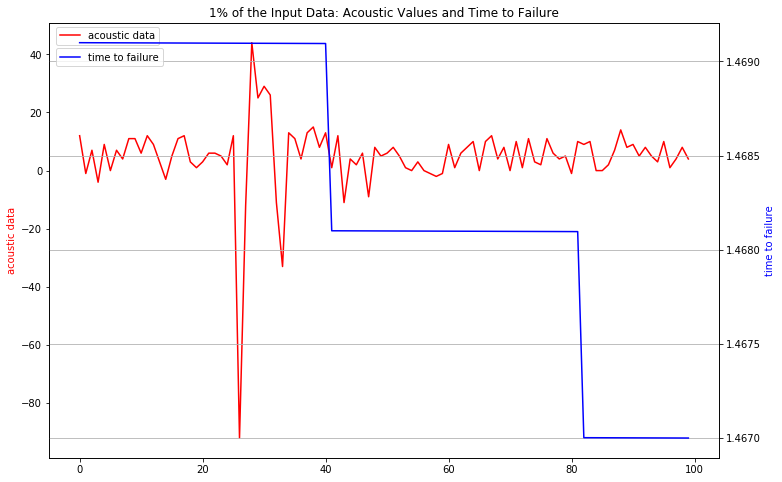

In [18]:
acoustic_values = input_data['acoustic_data'].values[::100]
time_to_failure_values = input_data['time_to_failure'].values[::100]

fig, ax1 = plt.subplots(figsize=(12, 8))
plt.title("1% of the Input Data: Acoustic Values and Time to Failure")
plt.plot(acoustic_values, color='r')
ax1.set_ylabel('acoustic data', color='r')
plt.legend(['acoustic data'], loc=(0.01, 0.95))
ax2 = ax1.twinx()
plt.plot(time_to_failure_values, color='b')
ax2.set_ylabel('time to failure', color='b')
plt.legend(['time to failure'], loc=(0.01, 0.9))
plt.grid(True)

In [19]:
i = 0
target = []
mydata = pd.DataFrame()
for chunk in pd.read_csv(FILE, chunksize=WINDOW,dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32 },nrows=100000):
    i += 1
    chunk['id'] = i
    extracted_features = extract_features(chunk.drop(columns=['time_to_failure']), column_id='id', n_jobs=1,default_fc_parameters=MinimalFCParameters())
    mydata = pd.concat([mydata, extracted_features])
    target.append(chunk.time_to_failure.iloc[-1])
    
mydata['time_to_failure'] = target
mydata.to_csv(r'ft_1m6.csv', index=False)

Feature Extraction: 100%|██████████| 1/1 [00:00<00:00, 850.94it/s]


In [12]:
mydata.head()

variable,acoustic_data__length,acoustic_data__maximum,acoustic_data__mean,acoustic_data__median,acoustic_data__minimum,acoustic_data__standard_deviation,acoustic_data__sum_values,acoustic_data__variance,time_to_failure
id,,,,,,,,,
1,15000.0,104.0,5.083667,5.0,-98.0,9.648005,76255.0,93.084000,1.465897
2,15000.0,30.0,4.939733,5.0,-20.0,3.933239,74096.0,15.470368,1.461699
3,15000.0,40.0,4.931600,5.0,-35.0,5.220331,73974.0,27.251855,1.458495
4,15000.0,34.0,4.761800,5.0,-19.0,3.950645,71427.0,15.607594,1.454197
5,15000.0,52.0,5.143667,5.0,-56.0,5.301606,77155.0,28.107027,1.449999


In [3]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [4]:
dataframe = pd.read_csv(r'ft_1m6.csv')
dataframe = dataframe.dropna(axis=1)
dataframe.shape

(7, 9)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataframe.drop(columns=['time_to_failure']), dataframe.time_to_failure, test_size=0.3)

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
from sklearn import preprocessing
print(y_train)
lab_enc = preprocessing.LabelEncoder()
y_train_encoded = lab_enc.fit_transform(y_train)
print(y_train_encoded)

3    1.454197
4    1.449999
0    1.465897
6    1.443598
Name: time_to_failure, dtype: float64
[2 1 3 0]


In [8]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
LR.fit(X_train,y_train_encoded)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [9]:
def create_model(optimizer='adam',activation='relu'):
    model = Sequential()
    model.add(Dense(64,
                    input_dim=X_train.shape[1],
                    #kernel_initializer='normal',
                    activation=activation                   
                   ))
    model.add(Dense(1,
                   #kernel_initializer='normal',
                   activation='linear'
                   ))
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [10]:
model = KerasRegressor(build_fn=create_model, epochs=50, batch_size=64, verbose=1, shuffle=True)

In [11]:
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(optimizer=optimizer,activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, verbose=1)
grid_result = grid.fit(X_train_scaled, y_train)
# summarize results
print("Best results were obtained using %s having loss : %f" % (grid_result.best_params_,grid_result.best_score_))


Fitting 3 folds for each of 56 candidates, totalling 168 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 168 out of 168 | elapsed:   26.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Epoch 1/50
4/4 [==============================] - 0s 24ms/step - loss: 1.9001
Epoch 2/50
4/4 [==============================] - 0s 233us/step - loss: 0.7930
Epoch 3/50
4/4 [==============================] - 0s 281us/step - loss: 0.3321
Epoch 4/50
4/4 [==============================] - 0s 320us/step - loss: 0.1403
Epoch 5/50
4/4 [==============================] - 0s 248us/step - loss: 0.0605
Epoch 6/50
4/4 [==============================] - 0s 291us/step - loss: 0.0273
Epoch 7/50
4/4 [==============================] - 0s 173us/step - loss: 0.0135
Epoch 8/50
4/4 [==============================] - 0s 340us/step - loss: 0.0077
Epoch 9/50
4/4 [==============================] - 0s 222us/step - loss: 0.0053
Epoch 10/50
4/4 [==============================] - 0s 265us/step - loss: 0.0043
Epoch 11/50
4/4 [==============================] - 0s 281us/step - loss: 0.0039
Epoch 12/50
4/4 [==============================] - 0s 439us/step - loss: 0.0037
Epoch 13/50
4/4 [==============================] -